# How to map a horizon in 3-D seismic data

This tutorial describes how to map stratigraphic horizons in a 3-D seismic volume using a variety of models. We start of really simple with a linear model prediction the depth (twt) of a horizon from a 1-D seismic trace. Then we explore the use of 1-D convolutional neural networks (CNN) for this task. Next, we go to two dimensions giving our model an idea of the surrounding traces.

## Setup ##
1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-4/tutorial-4.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


In [1]:
!pip install googledrivedownloader
!pip install segpy

     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 112kB 41.5MB/s 


In [2]:

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable




from google_drive_downloader import GoogleDriveDownloader as gdd

import segpy
from segpy.reader import create_reader




and download the 3-D seismic volume and the horizon:

In [3]:
gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='15o_M_BWTS_Y9TXen4IYVmdJFz0xbUk3i',
                                    dest_path='./horizon.txt',
                                    unzip=False)

and load the data:

In [4]:
filename = "./Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

scale the data:

In [5]:
data = (data-np.min(data))/(np.max(data)-np.min(data))

and sort the data by inlines, crosslines and times:

In [6]:
data = np.swapaxes(data, 1, 2)

(inlines, xlines, times) = data.shape

Next we load the interpretation:

In [7]:
# Load interpretation
t_0            = 2
time_range     = 1848
scaling_factor = data.shape[2]/time_range

# Load horizon saved as Kingdom interpretation (ascii)
f=open('./horizon.txt',"r")
lines=f.readlines()

t = []
for line in lines:
    t.append((float(line.split()[4])-t_0)*data.shape[2]/time_range)
f.close()

t = np.array(t).reshape((651, 951))

plot it:

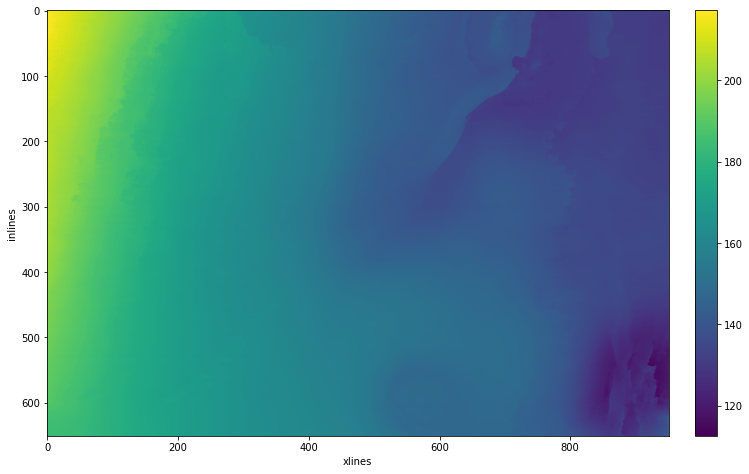

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(t)
plt.colorbar(fraction=0.0318, pad=0.04)
plt.xlabel('xlines')
plt.ylabel('inlines')
plt.show()

Now we calculate a scaling factor between the seismic data and the horizon in two-way traveltime and plot them together:

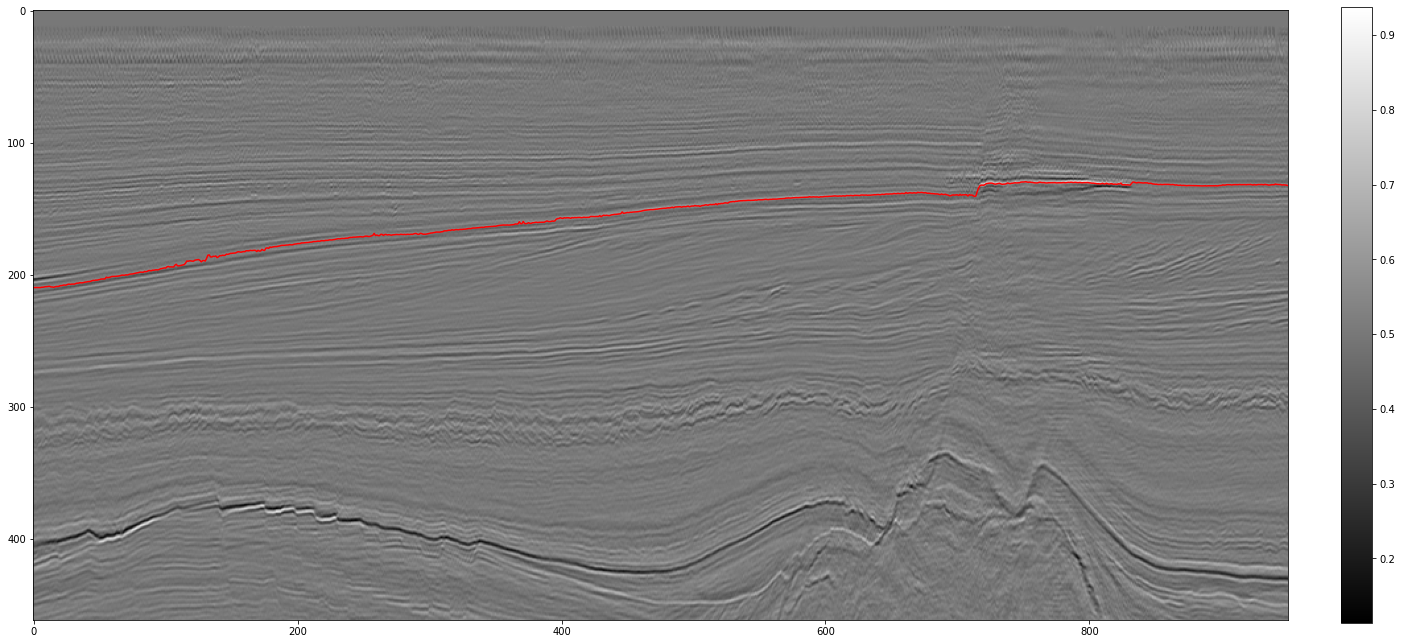

In [9]:

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[100,:,:]), 'gray')
plt.plot(t[100,:], 'red')
plt.colorbar(fraction=0.023, pad=0.04)
plt.show()

# 3-D CNN #

Okay, the prediction is a bit slow, maybe we can speed things up by simultaneously predicting the horizon for all traces in the batch:

In [10]:
wsize = 10

def cubify(line, xlines, batch_size):



  X = np.zeros((batch_size, wsize, wsize, times))
  y = np.zeros((batch_size, wsize*wsize))

  


  xlines = np.random.randint(wsize//2, xlines-wsize//2, batch_size)

  m = 0
  for xline in xlines:
    X[m,:,:,:] = data[line-wsize//2:line+wsize//2, xline-wsize//2:xline+wsize//2, :]

    y[m,:]     = t[line-wsize//2:line+wsize//2, xline-wsize//2:xline+wsize//2].reshape(wsize*wsize)
    m+=1

  return X, y





In [11]:
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,
                 data,
                 inlines,
                 xlines,
                 n_exp,
                 dim_in,
                 dim_out,
                 batch_size=32, 
                 shuffle=True):
        
        'Initialization'
        self.data   = data
        self.inlines = inlines
        self.xlines = xlines
        self.n_exp = n_exp
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_exp / self.batch_size))

    def __getitem__(self, index):
        # Generate data
        X, Y = self.__data_generation()

        return X, Y


    def __data_generation(self):
        'Generates data containing batch_size samples'
        
        # Initialization
        X    = np.zeros((self.batch_size, *self.dim_in, 1))
        y    = np.zeros((self.batch_size, self.dim_out, 1))

        self.per = self.batch_size//len(self.inlines)  

        # Generate data
        n = 0
        for inline in self.inlines:
            X[self.per*n:self.per*(n+1),:,:,:,0], y[self.per*n:self.per*(n+1),:,0] = cubify(inline, self.xlines, self.per)            
            n = n + 1
                        
        return X, y

    def __next__(self):
      if self.n >= self.max:
        self.n = 0
      result = self.__getitem__(self.n)
      self.n += 1
      return result

In [12]:

inlines_train = range(25,600,25)
inlines_val   = [113,213,313,413,513,613]

dim_in  = (wsize, wsize, times)
dim_out = wsize*wsize

n_exp = len(inlines_train)*xlines

datagen_train = DataGenerator(data,
                              inlines_train,
                              xlines,
                              n_exp,
                              dim_in,
                              dim_out,
                              batch_size=32, 
                              shuffle=True)


n_exp = len(inlines_val)*xlines

datagen_val = DataGenerator(data,
                            inlines_val,
                            xlines,
                            n_exp,
                            dim_in,
                            dim_out,
                            batch_size=32, 
                            shuffle=True)

In [13]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, Flatten, MaxPooling3D, Dropout


model = Sequential([Conv3D(16, 3, padding='same', activation='relu', input_shape=(wsize, wsize, times, 1)),
                    MaxPooling3D(),
                    Dropout(0.2),
                    Conv3D(32, 3, padding='same', activation='relu'),
                    MaxPooling3D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(wsize*wsize)])

model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics = ['mse'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 10, 462, 16)   448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 231, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 231, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 5, 231, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 2, 115, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 115, 32)     0         
_________________________________________________________________
flatten (Flatten)            (None, 14720)             0

In [14]:
history =  model.fit(datagen_train,
                     steps_per_epoch  = len(datagen_train),
                     validation_data  = datagen_val,
                     validation_steps = len(datagen_val),
                     epochs=100)

Epoch 1/100
683/683 [==============================] - 59s 40ms/step - loss: 20.7875 - mse: 1560.8629 - val_loss: 16.9068 - val_mse: 546.8047
Epoch 2/100
683/683 [==============================] - 27s 40ms/step - loss: 9.6277 - mse: 234.8668 - val_loss: 19.6162 - val_mse: 536.0582
Epoch 3/100
683/683 [==============================] - 27s 40ms/step - loss: 5.8779 - mse: 87.3651 - val_loss: 9.9225 - val_mse: 196.2121
Epoch 4/100
683/683 [==============================] - 27s 40ms/step - loss: 5.0022 - mse: 61.1217 - val_loss: 10.9190 - val_mse: 243.2502
Epoch 5/100
683/683 [==============================] - 27s 40ms/step - loss: 5.0197 - mse: 58.4408 - val_loss: 16.6102 - val_mse: 427.4368
Epoch 6/100
683/683 [==============================] - 27s 40ms/step - loss: 4.1735 - mse: 42.0744 - val_loss: 13.9253 - val_mse: 370.7372
Epoch 7/100
683/683 [==============================] - 27s 40ms/step - loss: 4.0156 - mse: 38.2305 - val_loss: 10.6046 - val_mse: 272.6736
Epoch 8/100
683/683 [===

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [15]:
wsize = 10

t_pred = np.zeros((inlines, xlines))

lines = range(5, 635, 5)

for line in lines:
  print(line)

  n_exp = xlines

  X = np.zeros((n_exp, wsize, wsize, times, 1))
  y = np.zeros((n_exp, wsize*wsize, 1))

  m = 0
  for xline in range(wsize//2, n_exp-wsize//2, wsize):
    X[m,:,:,:,0] = data[line-wsize//2:line+wsize//2, xline-wsize//2:xline+wsize//2, :]
    m+=1

  prediction = model.predict(X)

  m = 0
  for xline in range(wsize//2, n_exp-wsize//2, wsize):  
    t_pred[line-wsize//2:line+wsize//2,xline-wsize//2:xline+wsize//2] = prediction[m].reshape(wsize, wsize)
    m += 1

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630


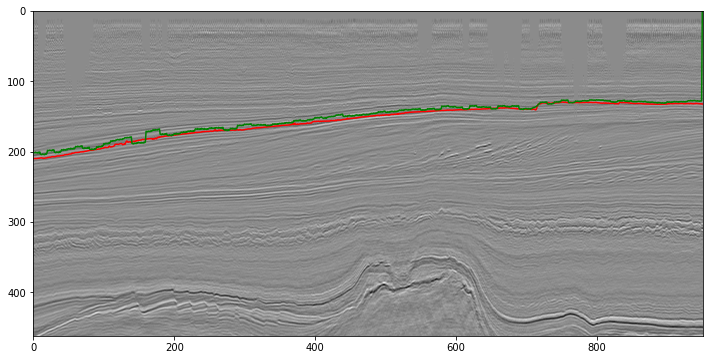

In [16]:
example = 100


plt.figure(figsize=(12,12))
plt.imshow(np.transpose(data[300,:,:]), 'gray')
plt.plot(t[example,:], c='red')
plt.plot(t_pred[example,:], c='green')
plt.show()

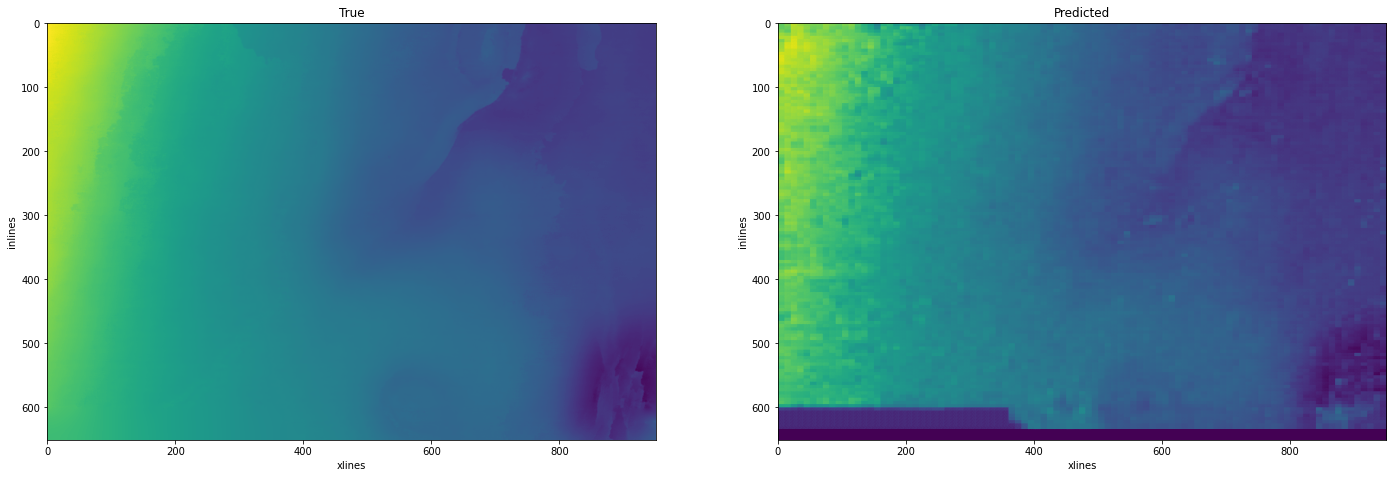

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(24,24))

axs[0].imshow(t)
axs[0].set_title('True')
axs[0].set_xlabel('xlines')
axs[0].set_ylabel('inlines')

im = axs[1].imshow(t_pred, vmin=np.min(t), vmax=np.max(t))
axs[1].set_title('Predicted')
axs[1].set_xlabel('xlines')
axs[1].set_ylabel('inlines')

plt.show()